In [ ]:
!mkdir -p ~/.kaggle
!mv kaggle.json ~/.kaggle/

In [ ]:
!kaggle datasets download -d gunavenkatdoddi/eye-diseases-classification



 97% 712M/736M [00:04<00:00, 211MB/s]

100% 736M/736M [00:04<00:00, 189MB/s]


In [ ]:
import zipfile
zipr= zipfile.ZipFile('/content/eye-diseases-classification.zip','r')
zipr.extractall('/content')
zipr.close()

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
dataset_path=os.listdir('/kaggle/input/eye-diseases-classification/dataset')
eye_types=os.listdir('/kaggle/input/eye-diseases-classification/dataset')
print("Categories: ",eye_types)
print("Types of Eyes in dataset: ",len(dataset_path))

Categories:  ['glaucoma', 'normal', 'diabetic_retinopathy', 'cataract']
Types of Eyes in dataset:  4


In [2]:
eyes=[]
for item in eye_types:
  # get all files name
  all_eyes=os.listdir('/kaggle/input/eye-diseases-classification/dataset'+'/'+item)
  # add them to the list
  for eye in all_eyes:
    eyes.append((item,str('/kaggle/input/eye-diseases-classification/dataset'+'/'+item)+'/'+eye))
# print(eyes)


In [3]:
eyes_df=pd.DataFrame(data=eyes,columns=['label','path'])

In [4]:
eyes_df.head()

,label,path
0,glaucoma,/kaggle/input/eye-diseases-classification/data...
1,glaucoma,/kaggle/input/eye-diseases-classification/data...
2,glaucoma,/kaggle/input/eye-diseases-classification/data...
3,glaucoma,/kaggle/input/eye-diseases-classification/data...
4,glaucoma,/kaggle/input/eye-diseases-classification/data...


In [5]:
print(len(eyes_df))

4217


In [6]:
eyes_count=eyes_df['label'].value_counts()
print("eyes in each category: ")
print(eyes_count)

eyes in each category: 
label
diabetic_retinopathy    1098
normal                  1074
cataract                1038
glaucoma                1007
Name: count, dtype: int64


In [7]:
from sklearn.model_selection import train_test_split
train_df, dummy_df = train_test_split(eyes_df, train_size=0.8, shuffle=True, random_state=123, stratify=eyes_df['label'])
valid_df, test_df = train_test_split(dummy_df, train_size=0.5, shuffle=True, random_state=123, stratify=dummy_df['label'])

In [10]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Define model parameters
img_size = 60
channels = 3
color = 'rgb'
batch_size = 32

# Custom function for determining test data batch size
ts_length = len(test_df)
test_batch_size = max(sorted([ts_length // n for n in range(1, ts_length + 1) if ts_length % n == 0 and ts_length / n <= 80]))
test_steps = ts_length // test_batch_size

# Function for data augmentation (this function returns the input image as it is)
def scalar(img):
    return img

# Create ImageDataGenerator for training, validation, and testing
tr_gen = ImageDataGenerator(preprocessing_function=scalar, horizontal_flip=True)
ts_gen = ImageDataGenerator(preprocessing_function=scalar)

# Flow training data from dataframe
train_gen = tr_gen.flow_from_dataframe(
    train_df, x_col='path',
    y_col='label',
    target_size=(img_size,img_size),
    class_mode='categorical',
    color_mode=color,
    shuffle=True,
    batch_size=batch_size
)

# Flow validation data from dataframe
valid_gen = ts_gen.flow_from_dataframe(
    valid_df, x_col='path',
    y_col='label',
    target_size=(img_size,img_size),
    class_mode='categorical',
    color_mode=color,
    shuffle=True,
    batch_size=batch_size
)

# Flow test data from dataframe (using custom batch size and no shuffling)
test_gen = ts_gen.flow_from_dataframe(
    test_df, x_col='path',
    y_col='label',
    target_size=(img_size,img_size),
    class_mode='categorical',
    color_mode=color,
    shuffle=False,
    batch_size=test_batch_size
)


Found 3373 validated image filenames belonging to 4 classes.
Found 422 validated image filenames belonging to 4 classes.
Found 422 validated image filenames belonging to 4 classes.


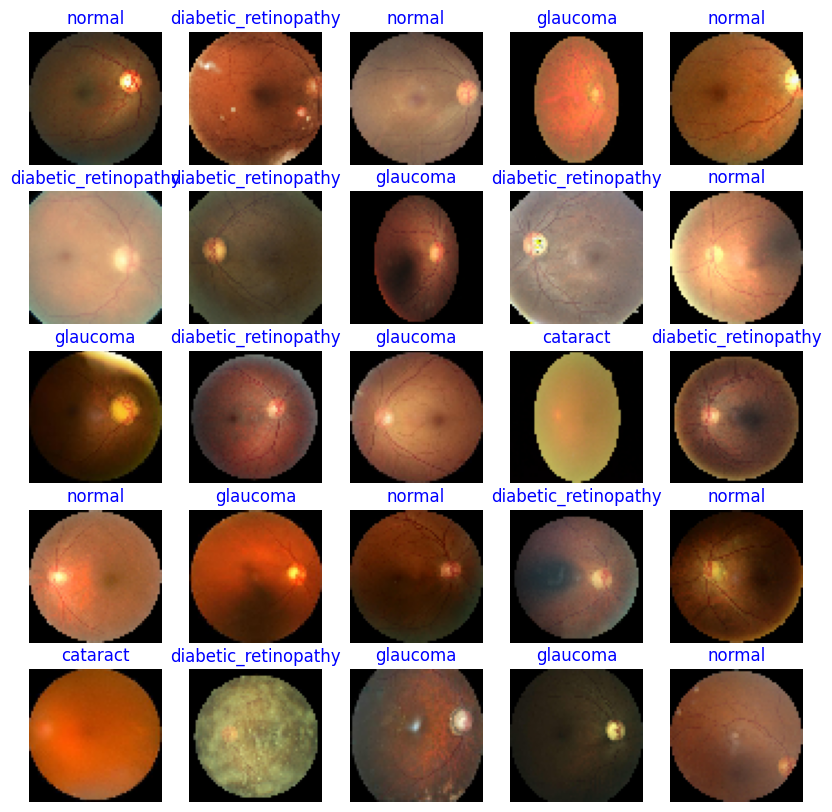

In [9]:
g_dict = train_gen.class_indices
classes = list(g_dict.keys())

images, labels = next(train_gen)
length = len(labels)
sample = min(length, 25)

plt.figure(figsize=(10, 10))

for i in range(sample):
    plt.subplot(5, 5, i + 1)
    image = images[i] / 255
    plt.imshow(image)
    index = np.argmax(labels[i])
    class_name = classes[index]
    plt.title(class_name, color='blue', fontsize=12)
    plt.axis('off')

plt.show()

In [11]:
def build_model(model_name):
    input_shape=(60,60,3)
    if model_name == "Sequential":
        model = Sequential([
            Conv2D(32, (3, 3),padding='valid', activation='relu', input_shape=input_shape),
            MaxPooling2D((2, 2),strides=2,padding='valid'),
            Conv2D(64, (3, 3),padding='valid', activation='relu'),
            MaxPooling2D((2, 2),strides=2,padding='valid'),
            Conv2D(128,(3, 3),padding='valid', activation='relu',),
            MaxPooling2D((2, 2),strides=2,padding='valid'),
            Conv2D(128,(3, 3),padding='valid', activation='relu'),
            MaxPooling2D((2, 2),strides=2,padding='valid'),
            Flatten(),
            Dense(128, activation='relu'),
            Dense(64, activation='relu'),
            Dropout(0.1),
            Dense(4, activation='softmax')
        ])
    elif model_name == "DenseNet121":
        base_model = DenseNet121(weights='imagenet', include_top=False, input_shape=input_shape)
        model = Sequential([
            base_model,
            Flatten(),
            Dense(512, activation='relu'),
            Dense(4, activation='softmax')
        ])
    elif model_name == "MobileNetV2":
        base_model = MobileNetV2(weights="imagenet",input_shape=(60,60,3),include_top=False,)
        model = Sequential([
            base_model,
            GlobalAveragePooling2D(),
            Dense(4, activation="softmax"),
        ])
    elif model_name == "VGG16":
        base_model = VGG16(weights='imagenet', include_top=False, input_shape=input_shape)
        model = Sequential([
            base_model,
            Flatten(),
            Dense(512, activation='relu'),
            Dense(4, activation='softmax')
        ])
    elif model_name == "VGG19":
        base_model = VGG19(weights='imagenet', include_top=False, input_shape=input_shape)
        model = Sequential([
            base_model,
            GlobalAveragePooling2D(),
            Dense(32, activation='relu'),
            Dense(4, activation='softmax')
        ])
    elif model_name == "ResNet50":
        base_model = ResNet50(weights='imagenet', include_top=False, input_shape=input_shape)
        model = Sequential([
            base_model,
            GlobalAveragePooling2D(),
            Dense(256, activation='relu'),
            Dense(4, activation='softmax')
        ])
    elif model_name == "Hybrid":
        model = build_hybrid_model()
    else:
        raise ValueError("Invalid model name!")

    # Compile model
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

    return model


In [12]:

def train_loop(train_gen, valid_gen, batch_size, epochs,model_name):
    '''
    This function takes train and validation data generators and runs training loop for defined number of epochs and batch size
    '''
    # Define model
    model = build_model(model_name)

    # Define callbacks
    early_stop = keras.callbacks.EarlyStopping(monitor='val_loss',mode='min', verbose=1, patience=3)
    checkpoint = keras.callbacks.ModelCheckpoint('best_model.keras', monitor='val_accuracy', save_best_only=True)


    # Train the model
    history = model.fit(train_gen,epochs=epochs,
                        validation_data=valid_gen,
                        callbacks=[early_stop, checkpoint])

    return model, history

In [13]:
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np

def evaluate_model_performance(model, test_gen):
    """
    Evaluate the performance of a trained model on the test data.

    Args:
    - model: Trained Keras model
    - test_gen: Test data generator
    """

    # Make predictions
    predictions = model.predict(test_gen)

    # Convert one-hot encoded predictions and true labels to categorical format
    predicted_labels = np.argmax(predictions, axis=1)
    true_labels = test_gen.classes

    # Compute classification report
    class_report = classification_report(true_labels, predicted_labels)

    # Compute confusion matrix
    conf_matrix = confusion_matrix(true_labels, predicted_labels)

    # Print classification report and confusion matrix
    print("Classification Report:")
    print(class_report)
    print("\nConfusion Matrix:")
    print(conf_matrix)

In [14]:
def plot_history(history):
    '''
    This function takes the history dictionary generated during model training and plots the training and validation accuracy and loss.
    '''

    # Plot training history
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']

    epochs = range(1, len(acc) + 1)

    plt.figure(figsize=(15, 6))
    plt.subplot(1, 2, 1)
    plt.plot(epochs, acc, 'b', label='Training acc')
    plt.plot(epochs, val_acc, 'r', label='Validation acc')
    plt.title('Training and validation accuracy')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(epochs, loss, 'b', label='Training loss')
    plt.plot(epochs, val_loss, 'r', label='Validation loss')
    plt.title('Training and validation loss')
    plt.legend()

    plt.show()

## Model Training

In [ ]:
batch_size = 32
epochs = 50

model1, history1 = train_loop(train_gen, valid_gen, batch_size, epochs, "Sequential")

Epoch 1/50

106/106 [==============================] - 22s 196ms/step - loss: 1.3084 - accuracy: 0.4907 - val_loss: 0.9926 - val_accuracy: 0.5687

Epoch 2/50

106/106 [==============================] - 20s 192ms/step - loss: 0.8191 - accuracy: 0.6324 - val_loss: 0.6851 - val_accuracy: 0.7109

Epoch 3/50

106/106 [==============================] - 20s 190ms/step - loss: 0.6421 - accuracy: 0.7296 - val_loss: 0.6759 - val_accuracy: 0.6801

Epoch 4/50

106/106 [==============================] - 20s 188ms/step - loss: 0.5799 - accuracy: 0.7521 - val_loss: 0.4689 - val_accuracy: 0.8318

Epoch 5/50

106/106 [==============================] - 20s 191ms/step - loss: 0.4810 - accuracy: 0.8043 - val_loss: 0.5116 - val_accuracy: 0.8009

Epoch 6/50

106/106 [==============================] - 20s 187ms/step - loss: 0.4683 - accuracy: 0.8129 - val_loss: 0.4880 - val_accuracy: 0.8199

Epoch 7/50

106/106 [==============================] - 20s 189ms/step - loss: 0.4417 - accuracy: 0.8283 - val_loss: 0.

In [ ]:
model1.save("cmodel1.h5")

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.

  saving_api.save_model(


In [ ]:
model2, history2 = train_loop(train_gen, valid_gen, batch_size, epochs, "DenseNet121")


29084464/29084464 [==============================] - 0s 0us/step

Epoch 1/50

106/106 [==============================] - 74s 416ms/step - loss: 0.7484 - accuracy: 0.6896 - val_loss: 1.6872 - val_accuracy: 0.6019

Epoch 2/50

106/106 [==============================] - 40s 372ms/step - loss: 0.4890 - accuracy: 0.8156 - val_loss: 0.4011 - val_accuracy: 0.8389

Epoch 3/50

106/106 [==============================] - 37s 352ms/step - loss: 0.4105 - accuracy: 0.8509 - val_loss: 1.0344 - val_accuracy: 0.6161

Epoch 4/50

106/106 [==============================] - 39s 369ms/step - loss: 0.3363 - accuracy: 0.8719 - val_loss: 0.3615 - val_accuracy: 0.8768

Epoch 5/50

106/106 [==============================] - 37s 351ms/step - loss: 0.6023 - accuracy: 0.8189 - val_loss: 77.6114 - val_accuracy: 0.2109

Epoch 6/50

106/106 [==============================] - 37s 345ms/step - loss: 0.5717 - accuracy: 0.7723 - val_loss: 0.5645 - val_accuracy: 0.7630

Epoch 7/50

106/106 [=============================

In [ ]:
model2.save("cmodel2.h5")

In [36]:
model3, history3 = train_loop(train_gen_mob, valid_gen_mob, batch_size, epochs, "MobileNetV2")


9406464/9406464 [==============================] - 0s 0us/step

Epoch 1/50

106/106 [==============================] - 41s 276ms/step - loss: 0.6031 - accuracy: 0.7954 - val_loss: 17.6875 - val_accuracy: 0.3152

Epoch 2/50

106/106 [==============================] - 29s 270ms/step - loss: 0.3234 - accuracy: 0.8817 - val_loss: 6.3629 - val_accuracy: 0.4242

Epoch 3/50

106/106 [==============================] - 28s 259ms/step - loss: 0.2589 - accuracy: 0.9034 - val_loss: 8.6010 - val_accuracy: 0.4408

Epoch 4/50

106/106 [==============================] - 27s 253ms/step - loss: 0.2434 - accuracy: 0.9078 - val_loss: 8.4960 - val_accuracy: 0.4194

Epoch 5/50

106/106 [==============================] - 28s 262ms/step - loss: 0.2052 - accuracy: 0.9226 - val_loss: 2.8439 - val_accuracy: 0.6351

Epoch 6/50

106/106 [==============================] - 27s 252ms/step - loss: 0.1822 - accuracy: 0.9333 - val_loss: 6.6901 - val_accuracy: 0.4668

Epoch 7/50

106/106 [==============================]

In [40]:
model3.save("cmodel3.h5")

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.

  saving_api.save_model(


In [ ]:
model4, history4 = train_loop(train_gen, valid_gen, batch_size, epochs, "VGG16")


58889256/58889256 [==============================] - 0s 0us/step

Epoch 1/50

106/106 [==============================] - 45s 404ms/step - loss: 2.3384 - accuracy: 0.2434 - val_loss: 1.3859 - val_accuracy: 0.2607

Epoch 2/50

106/106 [==============================] - 41s 388ms/step - loss: 1.3862 - accuracy: 0.2564 - val_loss: 1.3857 - val_accuracy: 0.2607

Epoch 3/50

106/106 [==============================] - 41s 389ms/step - loss: 1.3865 - accuracy: 0.2446 - val_loss: 1.3857 - val_accuracy: 0.2607

Epoch 4/50

106/106 [==============================] - 41s 385ms/step - loss: 1.3861 - accuracy: 0.2603 - val_loss: 1.3857 - val_accuracy: 0.2607

Epoch 5/50

106/106 [==============================] - 41s 385ms/step - loss: 1.3862 - accuracy: 0.2603 - val_loss: 1.3857 - val_accuracy: 0.2607

Epoch 6/50

106/106 [==============================] - 41s 385ms/step - loss: 1.3860 - accuracy: 0.2603 - val_loss: 1.3857 - val_accuracy: 0.2607

Epoch 6: early stopping


In [86]:
model4.save("cmodel4.h5")

In [45]:
model5, history5 = train_loop(train_gen, valid_gen, batch_size, epochs, "VGG19")

Epoch 1/50

106/106 [==============================] - 140s 1s/step - loss: 2.7540 - accuracy: 0.2742 - val_loss: 1.3893 - val_accuracy: 0.3175

Epoch 2/50

106/106 [==============================] - 137s 1s/step - loss: 1.1998 - accuracy: 0.4222 - val_loss: 1.1751 - val_accuracy: 0.4431

Epoch 3/50

106/106 [==============================] - 138s 1s/step - loss: 1.0010 - accuracy: 0.5200 - val_loss: 1.1153 - val_accuracy: 0.4882

Epoch 4/50

106/106 [==============================] - 137s 1s/step - loss: 0.8834 - accuracy: 0.5674 - val_loss: 0.8832 - val_accuracy: 0.5403

Epoch 5/50

106/106 [==============================] - 137s 1s/step - loss: 0.8527 - accuracy: 0.5864 - val_loss: 0.8762 - val_accuracy: 0.5569

Epoch 6/50

106/106 [==============================] - 135s 1s/step - loss: 0.8564 - accuracy: 0.5855 - val_loss: 0.8877 - val_accuracy: 0.5355

Epoch 7/50

106/106 [==============================] - 136s 1s/step - loss: 0.8763 - accuracy: 0.5763 - val_loss: 0.9096 - val_acc

In [85]:
model5.save("cmodel5.h5")

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.

  saving_api.save_model(


In [47]:
model6, history6 = train_loop(train_gen, valid_gen, batch_size, epochs, "ResNet50")


94765736/94765736 [==============================] - 0s 0us/step

Epoch 1/50

106/106 [==============================] - 74s 535ms/step - loss: 0.8226 - accuracy: 0.7038 - val_loss: 158.0141 - val_accuracy: 0.3199

Epoch 2/50

106/106 [==============================] - 54s 513ms/step - loss: 0.4097 - accuracy: 0.8527 - val_loss: 0.6021 - val_accuracy: 0.7678

Epoch 3/50

106/106 [==============================] - 54s 513ms/step - loss: 0.3475 - accuracy: 0.8627 - val_loss: 0.5816 - val_accuracy: 0.7962

Epoch 4/50

106/106 [==============================] - 54s 510ms/step - loss: 0.2876 - accuracy: 0.8936 - val_loss: 0.4468 - val_accuracy: 0.8246

Epoch 5/50

106/106 [==============================] - 53s 498ms/step - loss: 0.2666 - accuracy: 0.8989 - val_loss: 0.6471 - val_accuracy: 0.7773

Epoch 6/50

106/106 [==============================] - 52s 493ms/step - loss: 0.2534 - accuracy: 0.9072 - val_loss: 0.8365 - val_accuracy: 0.7962

Epoch 7/50

106/106 [============================

In [48]:
model6.save("cmodel6.h5")

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.

  saving_api.save_model(


## Model Summary

In [87]:
build_model(model_name="Sequential").summary()

Model: "sequential_16"

_________________________________________________________________

 Layer (type)                Output Shape              Param #   


 conv2d_26 (Conv2D)          (None, 58, 58, 32)        896       

                                                                 

 max_pooling2d_8 (MaxPoolin  (None, 29, 29, 32)        0         

 g2D)                                                            

                                                                 

 conv2d_27 (Conv2D)          (None, 27, 27, 64)        18496     

                                                                 

 max_pooling2d_9 (MaxPoolin  (None, 13, 13, 64)        0         

 g2D)                                                            

                                                                 

 conv2d_28 (Conv2D)          (None, 11, 11, 128)       73856     

                                                                 

 max_pooling2d_10 (MaxPooli  (None, 5

In [88]:
build_model(model_name="DenseNet121").summary()

Model: "sequential_17"

_________________________________________________________________

 Layer (type)                Output Shape              Param #   


 densenet121 (Functional)    (None, 1, 1, 1024)        7037504   

                                                                 

 flatten_14 (Flatten)        (None, 1024)              0         

                                                                 

 dense_41 (Dense)            (None, 512)               524800    

                                                                 

 dense_42 (Dense)            (None, 4)                 2052      

                                                                 


Total params: 7564356 (28.86 MB)

Trainable params: 7480708 (28.54 MB)

Non-trainable params: 83648 (326.75 KB)

_________________________________________________________________


In [89]:
build_model(model_name="MobileNetV2").summary()

Model: "sequential_18"

_________________________________________________________________

 Layer (type)                Output Shape              Param #   


 mobilenetv2_1.00_224 (Func  (None, 2, 2, 1280)        2257984   

 tional)                                                         

                                                                 

 global_average_pooling2d_6  (None, 1280)              0         

  (GlobalAveragePooling2D)                                       

                                                                 

 dense_43 (Dense)            (None, 4)                 5124      

                                                                 


Total params: 2263108 (8.63 MB)

Trainable params: 2228996 (8.50 MB)

Non-trainable params: 34112 (133.25 KB)

_________________________________________________________________


In [90]:
build_model(model_name="VGG16").summary()

Model: "sequential_19"

_________________________________________________________________

 Layer (type)                Output Shape              Param #   


 vgg16 (Functional)          (None, 1, 1, 512)         14714688  

                                                                 

 flatten_15 (Flatten)        (None, 512)               0         

                                                                 

 dense_44 (Dense)            (None, 512)               262656    

                                                                 

 dense_45 (Dense)            (None, 4)                 2052      

                                                                 


Total params: 14979396 (57.14 MB)

Trainable params: 14979396 (57.14 MB)

Non-trainable params: 0 (0.00 Byte)

_________________________________________________________________


In [91]:
build_model(model_name="VGG19").summary()

Model: "sequential_20"

_________________________________________________________________

 Layer (type)                Output Shape              Param #   


 vgg19 (Functional)          (None, 1, 1, 512)         20024384  

                                                                 

 global_average_pooling2d_7  (None, 512)               0         

  (GlobalAveragePooling2D)                                       

                                                                 

 dense_46 (Dense)            (None, 32)                16416     

                                                                 

 dense_47 (Dense)            (None, 4)                 132       

                                                                 


Total params: 20040932 (76.45 MB)

Trainable params: 20040932 (76.45 MB)

Non-trainable params: 0 (0.00 Byte)

_________________________________________________________________


In [92]:
build_model(model_name="ResNet50").summary()

Model: "sequential_21"

_________________________________________________________________

 Layer (type)                Output Shape              Param #   


 resnet50 (Functional)       (None, 2, 2, 2048)        23587712  

                                                                 

 global_average_pooling2d_8  (None, 2048)              0         

  (GlobalAveragePooling2D)                                       

                                                                 

 dense_48 (Dense)            (None, 256)               524544    

                                                                 

 dense_49 (Dense)            (None, 4)                 1028      

                                                                 


Total params: 24113284 (91.98 MB)

Trainable params: 24060164 (91.78 MB)

Non-trainable params: 53120 (207.50 KB)

_________________________________________________________________


## Accuracy and Loss Plot

In [15]:
import matplotlib.pyplot as plt

def plot_metrics(epochs, train_loss, train_accuracy, val_loss, val_accuracy):
    # Plot training and validation accuracy
    plt.plot(epochs, train_accuracy, label='Training Accuracy')
    plt.plot(epochs, val_accuracy, label='Validation Accuracy')
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.show()

    # Plot training and validation loss
    plt.plot(epochs, train_loss, label='Training Loss')
    plt.plot(epochs, val_loss, label='Validation Loss')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()


#### Plot for Sequential

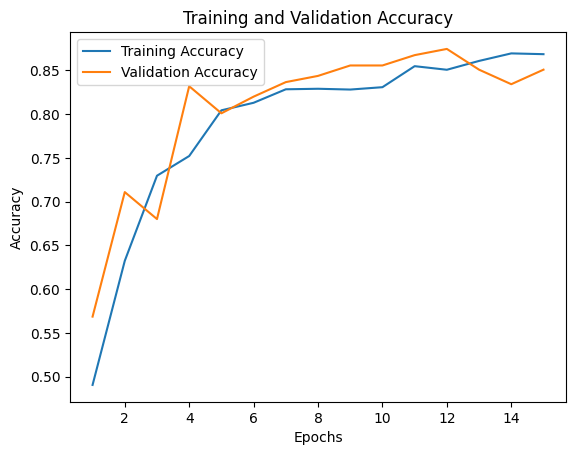

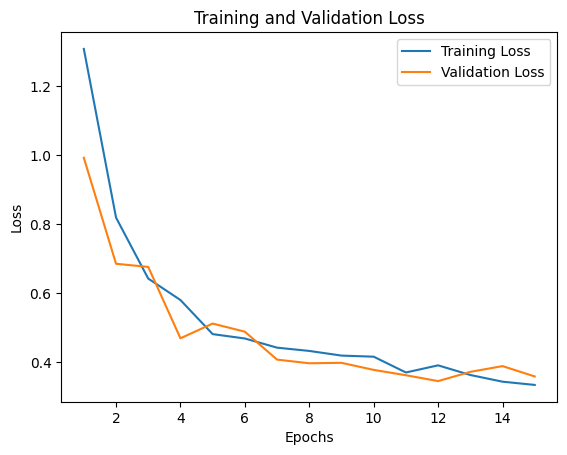

In [16]:
# Recorded epochs and corresponding metrics
epochs = range(1, 16)  # List of epochs
train_loss = [1.3084, 0.8191, 0.6421, 0.5799, 0.4810, 0.4683, 0.4417, 0.4322, 0.4187, 0.4155, 0.3697, 0.3904, 0.3624, 0.3430, 0.3336]
train_accuracy = [0.4907, 0.6324, 0.7296, 0.7521, 0.8043, 0.8129, 0.8283, 0.8289, 0.8280, 0.8307, 0.8547, 0.8506, 0.8607, 0.8693, 0.8684]
val_loss = [0.9926, 0.6851, 0.6759, 0.4689, 0.5116, 0.4880, 0.4070, 0.3964, 0.3977, 0.3772, 0.3617, 0.3447, 0.3715, 0.3882, 0.3582]
val_accuracy = [0.5687, 0.7109, 0.6801, 0.8318, 0.8009, 0.8199, 0.8365, 0.8436, 0.8555, 0.8555, 0.8673, 0.8744, 0.8507, 0.8341, 0.8507]

# Call the function to plot metrics
plot_metrics(epochs, train_loss, train_accuracy, val_loss, val_accuracy)


#### Plot for DenseNet121

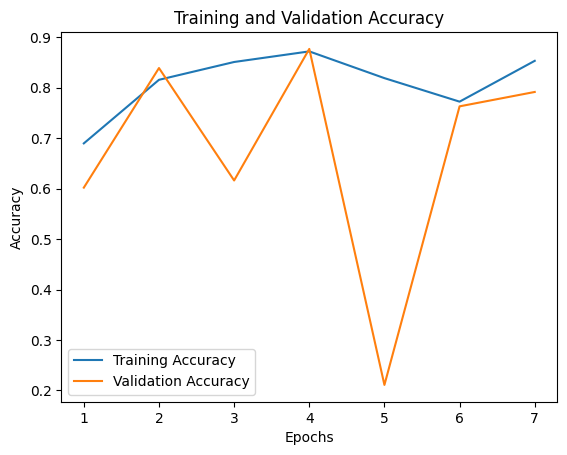

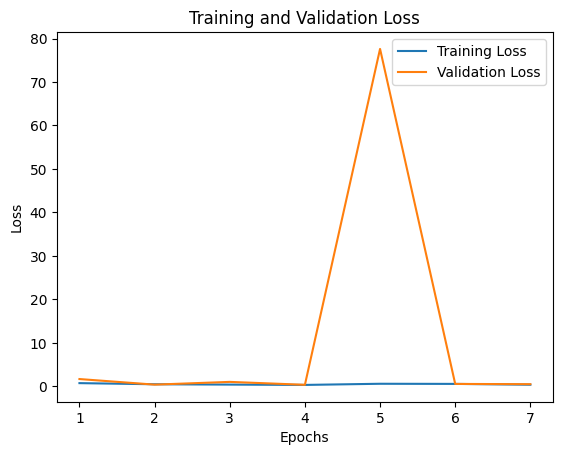

In [17]:
# Recorded epochs and corresponding metrics
epochs = range(1, 8)  # List of epochs
train_loss = [0.7484, 0.4890, 0.4105, 0.3363, 0.6023, 0.5717, 0.3829]
train_accuracy = [0.6896, 0.8156, 0.8509, 0.8719, 0.8189, 0.7723, 0.8532]
val_loss = [1.6872, 0.4011, 1.0344, 0.3615, 77.6114, 0.5645, 0.5081]
val_accuracy = [0.6019, 0.8389, 0.6161, 0.8768, 0.2109, 0.7630, 0.7915]

# Call the function to plot metrics
plot_metrics(epochs, train_loss, train_accuracy, val_loss, val_accuracy)

#### Plot for MobileNetV2

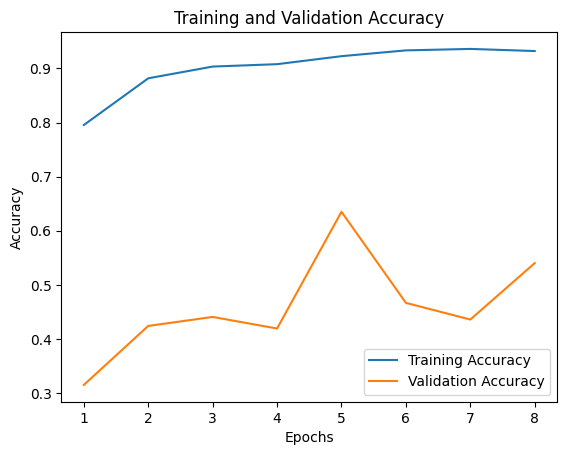

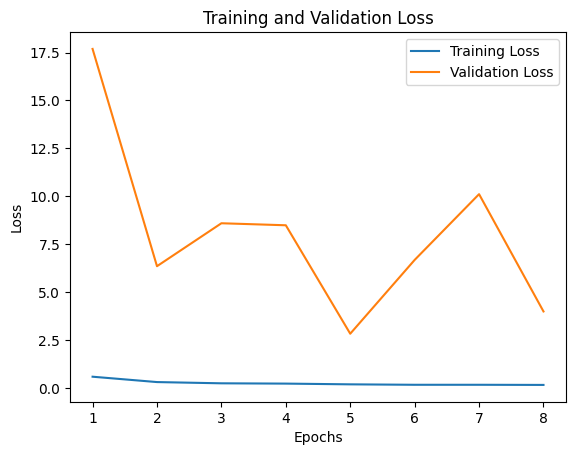

In [18]:
# Recorded epochs and corresponding metrics
epochs = range(1, 9)  # List of epochs
train_loss = [0.6031, 0.3234, 0.2589, 0.2434, 0.2052, 0.1822, 0.1823, 0.1749]
train_accuracy = [0.7954, 0.8817, 0.9034, 0.9078, 0.9226, 0.9333, 0.9360, 0.9321]
val_loss = [17.6875, 6.3629, 8.6010, 8.4960, 2.8439, 6.6901, 10.1178, 4.0044]
val_accuracy = [0.3152, 0.4242, 0.4408, 0.4194, 0.6351, 0.4668, 0.4360, 0.5403]

# Call the function to plot metrics
plot_metrics(epochs, train_loss, train_accuracy, val_loss, val_accuracy)

#### Plot for VGG16

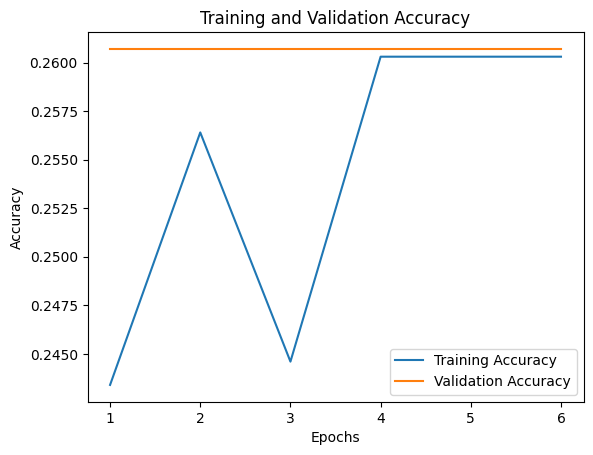

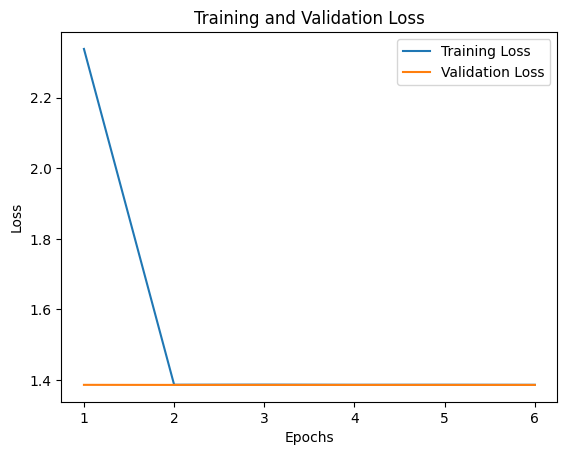

In [19]:
# Recorded epochs and corresponding metrics
epochs = range(1, 7)  # List of epochs
train_loss = [2.3384, 1.3862, 1.3865, 1.3861, 1.3862, 1.3860]
train_accuracy = [0.2434, 0.2564, 0.2446, 0.2603, 0.2603, 0.2603]
val_loss = [1.3859, 1.3857, 1.3857, 1.3857, 1.3857, 1.3857]
val_accuracy = [0.2607, 0.2607, 0.2607, 0.2607, 0.2607, 0.2607]

# Call the function to plot metrics
plot_metrics(epochs, train_loss, train_accuracy, val_loss, val_accuracy)

#### Plot for VGG19

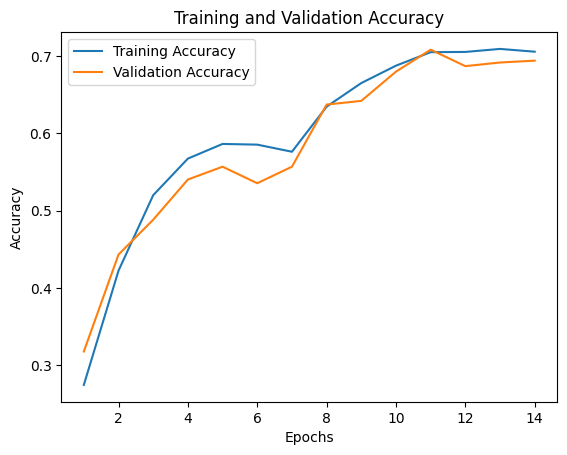

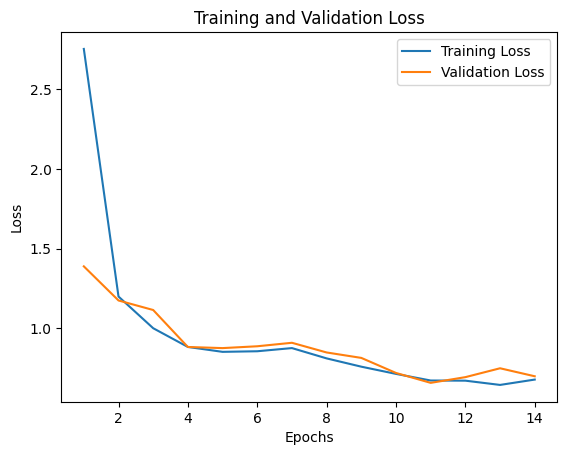

In [20]:
# Recorded epochs and corresponding metrics
epochs = range(1, 15)  # List of epochs
train_loss = [2.7540, 1.1998, 1.0010, 0.8834, 0.8527, 0.8564, 0.8763, 0.8116, 0.7596, 0.7143, 0.6728, 0.6718, 0.6451, 0.6787]
train_accuracy = [0.2742, 0.4222, 0.5200, 0.5674, 0.5864, 0.5855, 0.5763, 0.6347, 0.6653, 0.6878, 0.7053, 0.7056, 0.7095, 0.7059]
val_loss = [1.3893, 1.1751, 1.1153, 0.8832, 0.8762, 0.8877, 0.9096, 0.8488, 0.8147, 0.7202, 0.6581, 0.6939, 0.7496, 0.6994]
val_accuracy = [0.3175, 0.4431, 0.4882, 0.5403, 0.5569, 0.5355, 0.5569, 0.6374, 0.6422, 0.6801, 0.7085, 0.6872, 0.6919, 0.6943]

# Call the function to plot metrics
plot_metrics(epochs, train_loss, train_accuracy, val_loss, val_accuracy)

#### Plot for ResNet50

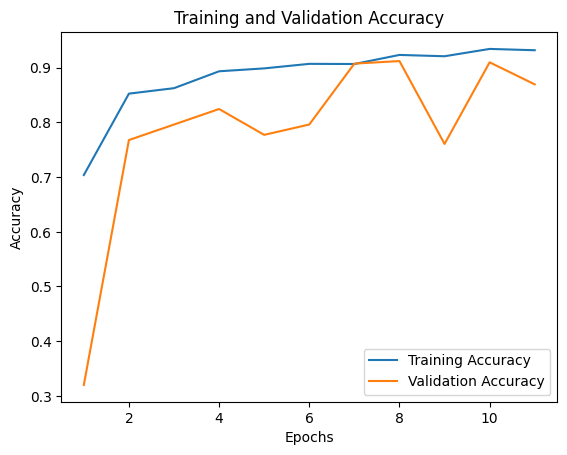

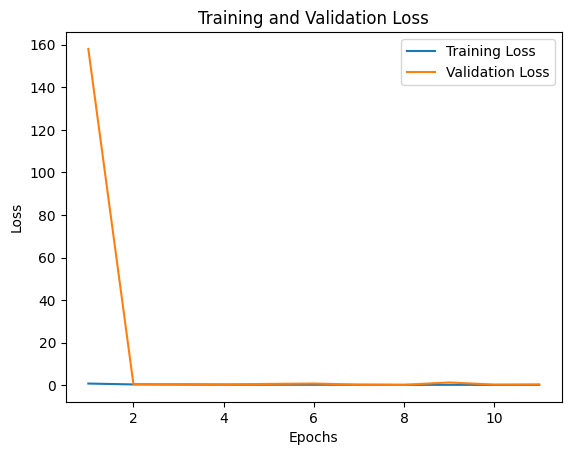

In [21]:
# Recorded epochs and corresponding metrics
epochs = range(1, 12)  # List of epochs
train_loss = [0.8226, 0.4097, 0.3475, 0.2876, 0.2666, 0.2534, 0.2414, 0.1981, 0.2266, 0.1807, 0.1904]
train_accuracy = [0.7038, 0.8527, 0.8627, 0.8936, 0.8989, 0.9072, 0.9069, 0.9235, 0.9211, 0.9345, 0.9321]
val_loss = [158.0141, 0.6021, 0.5816, 0.4468, 0.6471, 0.8365, 0.3120, 0.2311, 1.3351, 0.3339, 0.4217]
val_accuracy = [0.3199, 0.7678, 0.7962, 0.8246, 0.7773, 0.7962, 0.9076, 0.9123, 0.7607, 0.9100, 0.8697]

# Call the function to plot metrics
plot_metrics(epochs, train_loss, train_accuracy, val_loss, val_accuracy)

In [49]:
import cv2
import numpy as np
from tensorflow.keras.models import load_model

In [94]:
m1 = keras.models.load_model('cmodel1.h5')

In [95]:
m2 = keras.models.load_model('cmodel2.h5')

In [96]:
m3 = keras.models.load_model('cmodel3.h5')

In [97]:
m4 = keras.models.load_model('cmodel4.h5')

In [98]:
m5 = keras.models.load_model('cmodel5.h5')

In [99]:
m6 = keras.models.load_model('cmodel6.h5')

### Sequential

In [112]:
predictions = m1.predict(test_gen)
predicted_labels = np.argmax(predictions, axis=1)
true_labels = test_gen.classes
class_report = classification_report(true_labels, predicted_labels)
conf_matrix = confusion_matrix(true_labels, predicted_labels)
print(class_report)
print(conf_matrix)

211/211 [==============================] - 3s 13ms/step

              precision    recall  f1-score   support



           0       0.67      0.88      0.76       104

           1       0.99      0.99      0.99       110

           2       0.79      0.50      0.61       101

           3       0.71      0.75      0.73       107



    accuracy                           0.78       422

   macro avg       0.79      0.78      0.77       422

weighted avg       0.79      0.78      0.78       422



[[ 92   0   8   4]

 [  0 109   0   1]

 [ 23   1  50  27]

 [ 22   0   5  80]]


### DenseNet121

In [110]:
predictions = m2.predict(test_gen)
predicted_labels = np.argmax(predictions, axis=1)
true_labels = test_gen.classes
class_report = classification_report(true_labels, predicted_labels)
conf_matrix = confusion_matrix(true_labels, predicted_labels)
print(class_report)
print(conf_matrix)

211/211 [==============================] - 6s 28ms/step

              precision    recall  f1-score   support



           0       0.65      0.98      0.78       104

           1       1.00      0.98      0.99       110

           2       0.79      0.46      0.58       101

           3       0.75      0.70      0.72       107



    accuracy                           0.78       422

   macro avg       0.80      0.78      0.77       422

weighted avg       0.80      0.78      0.77       422



[[102   0   2   0]

 [  2 108   0   0]

 [ 30   0  46  25]

 [ 22   0  10  75]]


### MobileNetV2

In [107]:
predictions = m3.predict(test_gen)
predicted_labels = np.argmax(predictions, axis=1)
true_labels = test_gen.classes
class_report = classification_report(true_labels, predicted_labels)
conf_matrix = confusion_matrix(true_labels, predicted_labels)
print(class_report)
print(conf_matrix)

211/211 [==============================] - 4s 16ms/step

              precision    recall  f1-score   support



           0       0.35      0.98      0.52       104

           1       0.99      0.76      0.86       110

           2       0.77      0.37      0.50       101

           3       0.00      0.00      0.00       107



    accuracy                           0.53       422

   macro avg       0.53      0.53      0.47       422

weighted avg       0.53      0.53      0.47       422



[[102   0   2   0]

 [ 26  84   0   0]

 [ 64   0  37   0]

 [ 97   1   9   0]]


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

  _warn_prf(average, modifier, msg_start, len(result))

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

  _warn_prf(average, modifier, msg_start, len(result))

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

  _warn_prf(average, modifier, msg_start, len(result))


### VGG16

In [111]:
predictions = m4.predict(test_gen)
predicted_labels = np.argmax(predictions, axis=1)
true_labels = test_gen.classes
class_report = classification_report(true_labels, predicted_labels)
conf_matrix = confusion_matrix(true_labels, predicted_labels)
print(class_report)
print(conf_matrix)

211/211 [==============================] - 4s 21ms/step

              precision    recall  f1-score   support



           0       0.00      0.00      0.00       104

           1       0.26      1.00      0.41       110

           2       0.00      0.00      0.00       101

           3       0.00      0.00      0.00       107



    accuracy                           0.26       422

   macro avg       0.07      0.25      0.10       422

weighted avg       0.07      0.26      0.11       422



[[  0 104   0   0]

 [  0 110   0   0]

 [  0 101   0   0]

 [  0 107   0   0]]


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

  _warn_prf(average, modifier, msg_start, len(result))

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

  _warn_prf(average, modifier, msg_start, len(result))

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

  _warn_prf(average, modifier, msg_start, len(result))


### VGG19

In [105]:
predictions = m5.predict(test_gen)
predicted_labels = np.argmax(predictions, axis=1)
true_labels = test_gen.classes
class_report = classification_report(true_labels, predicted_labels)
conf_matrix = confusion_matrix(true_labels, predicted_labels)
print(class_report)
print(conf_matrix)

211/211 [==============================] - 8s 39ms/step

              precision    recall  f1-score   support



           0       0.65      0.53      0.58       104

           1       0.95      0.95      0.95       110

           2       0.56      0.34      0.42       101

           3       0.60      0.94      0.74       107



    accuracy                           0.70       422

   macro avg       0.69      0.69      0.67       422

weighted avg       0.69      0.70      0.68       422



[[ 55   2  21  26]

 [  0 104   3   3]

 [ 29   1  34  37]

 [  1   2   3 101]]


### ResNet50

In [104]:
predictions = m6.predict(test_gen)
predicted_labels = np.argmax(predictions, axis=1)
true_labels = test_gen.classes
class_report = classification_report(true_labels, predicted_labels)
conf_matrix = confusion_matrix(true_labels, predicted_labels)
print(class_report)
print(conf_matrix)

211/211 [==============================] - 8s 37ms/step

              precision    recall  f1-score   support



           0       0.67      0.97      0.80       104

           1       0.99      0.99      0.99       110

           2       0.81      0.63      0.71       101

           3       0.89      0.69      0.78       107



    accuracy                           0.82       422

   macro avg       0.84      0.82      0.82       422

weighted avg       0.84      0.82      0.82       422



[[101   0   1   2]

 [  1 109   0   0]

 [ 30   0  64   7]

 [ 18   1  14  74]]


### CNN Sequential Model using GroupKfold

In [15]:
import cv2
path='/kaggle/input/eye-diseases-classification/dataset/'
im_size=60
images=[]
labels=[]
for i in eye_types:
  data_path=path+str(i)
  filenames = [i for i in os.listdir(data_path)]
  for f in filenames:
    img = cv2.imread(data_path+'/'+f)
    img = cv2.resize(img,(im_size,im_size))
    images.append(img)
    labels.append(i)

In [16]:
images = np.array(images)
images=images.astype('float32')/255.0
images.shape

(4217, 60, 60, 3)

In [17]:
labels[:5]

['glaucoma', 'glaucoma', 'glaucoma', 'glaucoma', 'glaucoma']

In [18]:
from sklearn.preprocessing import OneHotEncoder
y=eyes_df['label'].values
print(y[:5])

['glaucoma' 'glaucoma' 'glaucoma' 'glaucoma' 'glaucoma']


In [19]:
y = y.reshape(-1, 1)
oneHot = OneHotEncoder(sparse=False)
oneHot.fit(y)
Y = oneHot.transform(y)
Y.shape

/opt/conda/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


(4217, 4)

In [20]:
from sklearn.utils import shuffle
images,Y=shuffle(images,Y,random_state=42)

In [21]:
images_train, images_temp, Y_train, Y_temp = train_test_split(images, Y, test_size=0.2, random_state=42)
images_valid, images_test, Y_valid, Y_test = train_test_split(images_temp, Y_temp, test_size=0.5, random_state=42)

In [22]:
images_tv = np.concatenate((images_train, images_valid), axis=0)
Y_tv = np.concatenate((Y_train, Y_valid), axis=0)
images_tv,Y_tv=shuffle(images_tv,Y_tv,random_state=42)

In [29]:
from tensorflow.keras.models import Sequential  # Import Sequential from keras.models
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense
from tensorflow.keras.callbacks import EarlyStopping

early_stopping = EarlyStopping(monitor='val_accuracy', mode='max', verbose=1, patience=5)

model_g = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(60, 60, 3)),
    MaxPooling2D((2, 2)),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Flatten(),
    Dense(128, activation='relu'),
    Dense(4, activation='softmax')
])
model_g.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model_g.summary()

Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_6 (Conv2D)               │ (None, 58, 58, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_6 (MaxPooling2D)  │ (None, 29, 29, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 27, 27, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_7 (MaxPooling2D)  │ (None, 13, 13, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_8 (Conv2D)               │ (None, 11, 11, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_8 (MaxPooling2D)  │ (None, 5, 5, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_2 (Flatten)             │ (None, 3200)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 128)            │       409,728 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 4)              │           516 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 503,492 (1.92 MB)

 Trainable params: 503,492 (1.92 MB)

 Non-trainable params: 0 (0.00 B)

In [30]:
# from tensorflow.keras.models import Sequential
# from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
# from tensorflow.keras.regularizers import l1, l2
# from tensorflow.keras.applications import EfficientNetB3

# # Load EfficientNetB3 as base model
# base_model = EfficientNetB3(include_top=False, weights="imagenet", input_shape=(60, 60, 3), pooling='max')

# modelR = Sequential([
#     base_model,  # Use EfficientNetB3 as base model
#     Dropout(0.1),  # Dropout layer with 50% dropout rate
#     BatchNormalization(),  # Batch normalization layer
#     Dense(256, activation='relu', kernel_regularizer=l2(0.01), bias_regularizer=l2(0.01)),  # Dense layer with L2 regularization
#     Dropout(0.1),  # Another dropout layer
#     Dense(4, activation='softmax')  # Output layer
# ])

# modelR.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
# modelR.summary()


In [31]:
# # Assuming you have your training data (X_train, Y_train) and validation data (X_valid, Y_valid)

# # Fit the model
# history = model_g.fit(
#     images_train, Y_train,
#     batch_size=32,
#     epochs=100,
#     validation_data=(images_valid, Y_valid),
#     callbacks=[early_stopping]
# )


In [32]:
from sklearn.model_selection import GroupKFold
from sklearn.metrics import classification_report, confusion_matrix

group_kfold = GroupKFold(n_splits=3)

all_predictions = []
all_true_labels = []

for train_index, test_index in group_kfold.split(images_tv, Y_tv, groups=labels[422:]):
    x_train, x_test = images_tv[train_index], images_tv[test_index]
    y_train, y_test = Y_tv[train_index], Y_tv[test_index]
    model_g.fit(x_train, y_train, epochs=100, validation_data=(x_test, y_test), batch_size=32, callbacks=[early_stopping])

    predictions_proba = model_g.predict(x_test)
    predictions = np.argmax(predictions_proba, axis=1)

    all_predictions.extend(predictions)
    all_true_labels.extend(np.argmax(y_test, axis=1))

Epoch 1/100
28/85 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.3351 - loss: 1.3401

W0000 00:00:1713723809.577150      93 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - accuracy: 0.4064 - loss: 1.2411

W0000 00:00:1713723812.168088      93 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1713723812.776561      93 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


85/85 ━━━━━━━━━━━━━━━━━━━━ 6s 48ms/step - accuracy: 0.4074 - loss: 1.2394 - val_accuracy: 0.6639 - val_loss: 0.7647
Epoch 2/100
40/85 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.6293 - loss: 0.8193

W0000 00:00:1713723813.600548      90 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.6513 - loss: 0.7848 - val_accuracy: 0.6703 - val_loss: 0.7925
Epoch 3/100
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.7051 - loss: 0.6942 - val_accuracy: 0.7359 - val_loss: 0.5995
Epoch 4/100
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.7595 - loss: 0.5637 - val_accuracy: 0.7596 - val_loss: 0.5637
Epoch 5/100
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.8000 - loss: 0.4786 - val_accuracy: 0.8024 - val_loss: 0.5131
Epoch 6/100
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.8096 - loss: 0.4619 - val_accuracy: 0.7832 - val_loss: 0.5473
Epoch 7/100
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.8202 - loss: 0.4352 - val_accuracy: 0.8197 - val_loss: 0.4575
Epoch 8/100
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.8462 - loss: 0.3803 - val_accuracy: 0.8160 - val_loss: 0.4611
Epoch 9/100
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.8742 - loss: 0.3460 - val_accuracy: 0.8224 - val_loss: 0.4

W0000 00:00:1713723822.215724      93 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


35/35 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step


W0000 00:00:1713723822.605304      91 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


Epoch 1/100
86/86 ━━━━━━━━━━━━━━━━━━━━ 3s 36ms/step - accuracy: 0.8720 - loss: 0.3818 - val_accuracy: 0.9330 - val_loss: 0.1857
Epoch 2/100
40/86 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9086 - loss: 0.2462

W0000 00:00:1713723826.088225      90 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


86/86 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9058 - loss: 0.2539 - val_accuracy: 0.8594 - val_loss: 0.3385
Epoch 3/100
86/86 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.8981 - loss: 0.2618 - val_accuracy: 0.9106 - val_loss: 0.2279
Epoch 4/100
86/86 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9238 - loss: 0.1949 - val_accuracy: 0.9134 - val_loss: 0.2066
Epoch 5/100
86/86 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9286 - loss: 0.1780 - val_accuracy: 0.8864 - val_loss: 0.2750
Epoch 6/100
86/86 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9305 - loss: 0.1789 - val_accuracy: 0.9115 - val_loss: 0.2245
Epoch 6: early stopping
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step


W0000 00:00:1713723828.929429      90 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


Epoch 1/100
68/68 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step - accuracy: 0.9176 - loss: 0.2158

W0000 00:00:1713723832.558697      93 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


68/68 ━━━━━━━━━━━━━━━━━━━━ 5s 67ms/step - accuracy: 0.9175 - loss: 0.2160 - val_accuracy: 0.9513 - val_loss: 0.1580
Epoch 2/100
68/68 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9262 - loss: 0.2089 - val_accuracy: 0.9600 - val_loss: 0.1324
Epoch 3/100
68/68 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9408 - loss: 0.1606 - val_accuracy: 0.9550 - val_loss: 0.1352
Epoch 4/100
68/68 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9527 - loss: 0.1403 - val_accuracy: 0.9507 - val_loss: 0.1410
Epoch 5/100
68/68 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9384 - loss: 0.1498 - val_accuracy: 0.9254 - val_loss: 0.1917
Epoch 6/100
68/68 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9504 - loss: 0.1438 - val_accuracy: 0.9415 - val_loss: 0.1527
Epoch 7/100
68/68 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9660 - loss: 0.0995 - val_accuracy: 0.9402 - val_loss: 0.1574
Epoch 7: early stopping
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step


In [34]:
# Compile model_g if it's not already compiled
model_g.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Evaluate the model on the test data
test_loss, test_accuracy = model_g.evaluate(x_test, y_test)

print("Test Loss:", test_loss)
print("Test Accuracy:", test_accuracy)

37/51 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9399 - loss: 0.1657 

W0000 00:00:1713723918.954033      93 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


51/51 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.9398 - loss: 0.1643
Test Loss: 0.1573631465435028
Test Accuracy: 0.9402341246604919


## Hybrid Model

In [38]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import cv2
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from keras.applications import VGG19
from keras.models import Model, Sequential
from keras.layers import GlobalAveragePooling2D, Dense, Dropout, Input, concatenate, Conv2D, MaxPooling2D, Flatten
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping  # Import EarlyStopping callback

# Define Early Stopping
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

# Load Pre-trained VGG19 Model
vgg_model = VGG19(weights='imagenet', include_top=False, input_shape=(im_size, im_size, 3))

# Rename Layers to Ensure Uniqueness
for layer in vgg_model.layers:
    layer.name = 'vgg_' + layer.name

# Freeze Layers
for layer in vgg_model.layers:
    layer.trainable = False

# Sequential model to replace ResNet50
hb_model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(im_size, im_size, 3)),
    MaxPooling2D((2, 2)),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Flatten(),
    Dense(256, activation='relu'),  # Update this layer to produce the correct output shape
    Dense(4, activation='softmax')
])

# Compile Model
hb_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
hb_model.summary()

Model: "sequential_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_12 (Conv2D)              │ (None, 58, 58, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_12 (MaxPooling2D) │ (None, 29, 29, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_13 (Conv2D)              │ (None, 27, 27, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_13 (MaxPooling2D) │ (None, 13, 13, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_14 (Conv2D)              │ (None, 11, 11, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_14 (MaxPooling2D) │ (None, 5, 5, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_4 (Flatten)             │ (None, 3200)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_12 (Dense)                │ (None, 256)            │       819,456 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_13 (Dense)                │ (None, 4)              │         1,028 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 913,732 (3.49 MB)

 Trainable params: 913,732 (3.49 MB)

 Non-trainable params: 0 (0.00 B)

In [36]:
history = hb_model.fit(
    x=[images_tv, images_tv, images_tv],  # Input data for three models
    y=Y_tv,  # Target labels
    batch_size=32,
    epochs=100,  # Increase epochs to allow early stopping to take effect
    validation_split=0.2,
    callbacks=[early_stopping]  # Pass EarlyStopping callback
)

Epoch 1/100
27/95 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.2859 - loss: 1.3814

W0000 00:00:1713724287.170417      91 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


95/95 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step - accuracy: 0.3931 - loss: 1.2671

W0000 00:00:1713724294.677540      91 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1713724295.452534      91 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


95/95 ━━━━━━━━━━━━━━━━━━━━ 12s 94ms/step - accuracy: 0.3941 - loss: 1.2657 - val_accuracy: 0.6337 - val_loss: 0.8493
Epoch 2/100
95/95 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.6631 - loss: 0.7922 - val_accuracy: 0.7470 - val_loss: 0.6323
Epoch 3/100
95/95 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.7481 - loss: 0.6221 - val_accuracy: 0.7655 - val_loss: 0.5603
Epoch 4/100
95/95 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.7749 - loss: 0.5538 - val_accuracy: 0.7734 - val_loss: 0.5247
Epoch 5/100
95/95 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.7888 - loss: 0.4930 - val_accuracy: 0.7945 - val_loss: 0.4989
Epoch 6/100
95/95 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.8382 - loss: 0.4386 - val_accuracy: 0.8011 - val_loss: 0.4628
Epoch 7/100
95/95 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.8197 - loss: 0.4359 - val_accuracy: 0.8221 - val_loss: 0.4421
Epoch 8/100
95/95 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.8225 - loss: 0.4311 - val_accuracy: 0.8169 - val_loss: 0

In [37]:
# Compile model_g if it's not already compiled
hb_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Evaluate the model on the test data
test_loss, test_accuracy = hb_model.evaluate(x_test, y_test)

print("Test Loss:", test_loss)
print("Test Accuracy:", test_accuracy)

40/51 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9110 - loss: 0.2258 

W0000 00:00:1713724354.986797      90 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


51/51 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.9069 - loss: 0.2391
Test Loss: 0.28210344910621643
Test Accuracy: 0.8927911520004272


In [40]:
from sklearn.model_selection import GroupKFold
from sklearn.metrics import classification_report, confusion_matrix
from keras.callbacks import EarlyStopping
import numpy as np

group_kfold = GroupKFold(n_splits=3)

all_predictions = []
all_true_labels = []

for train_index, test_index in group_kfold.split(images_tv, Y_tv, groups=labels[422:]):
    x_train, x_test = images_tv[train_index], images_tv[test_index]
    y_train, y_test = Y_tv[train_index], Y_tv[test_index]
    
    # Define Early Stopping based on validation accuracy
    early_stopping = EarlyStopping(monitor='val_accuracy', mode='max', verbose=1, patience=5)
    
    # Train the model
    hb_model.fit(x_train, y_train, epochs=100, validation_data=(x_test, y_test), batch_size=32, callbacks=[early_stopping])

    # Evaluate the model on the test data
    predictions_proba = hb_model.predict(x_test)
    predictions = np.argmax(predictions_proba, axis=1)

    # Store predictions and true labels
    all_predictions.extend(predictions)
    all_true_labels.extend(np.argmax(y_test, axis=1))

Epoch 1/100
27/85 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.2841 - loss: 1.3873

W0000 00:00:1713724452.925014      90 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - accuracy: 0.3833 - loss: 1.2600

W0000 00:00:1713724455.497682      90 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1713724456.104789      90 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


85/85 ━━━━━━━━━━━━━━━━━━━━ 6s 44ms/step - accuracy: 0.3846 - loss: 1.2581 - val_accuracy: 0.6066 - val_loss: 1.0134
Epoch 2/100
85/85 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.6312 - loss: 0.8448 - val_accuracy: 0.7304 - val_loss: 0.6352
Epoch 3/100
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.7178 - loss: 0.6450 - val_accuracy: 0.7760 - val_loss: 0.5651
Epoch 4/100
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.7627 - loss: 0.5826 - val_accuracy: 0.7796 - val_loss: 0.5334
Epoch 5/100
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.7764 - loss: 0.5477 - val_accuracy: 0.8015 - val_loss: 0.4982
Epoch 6/100
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.8125 - loss: 0.4470 - val_accuracy: 0.7960 - val_loss: 0.5123
Epoch 7/100
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.8231 - loss: 0.4292 - val_accuracy: 0.8179 - val_loss: 0.4704
Epoch 8/100
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.8494 - loss: 0.3839 - val_accuracy: 0.8024 - val_loss: 0.

W0000 00:00:1713724470.151999      91 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


35/35 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step
Epoch 1/100
86/86 ━━━━━━━━━━━━━━━━━━━━ 2s 24ms/step - accuracy: 0.9191 - loss: 0.2784 - val_accuracy: 0.9590 - val_loss: 0.1596
Epoch 2/100
31/86 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9431 - loss: 0.1762

W0000 00:00:1713724473.000581      93 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


86/86 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.9341 - loss: 0.1838 - val_accuracy: 0.9572 - val_loss: 0.1547
Epoch 3/100
86/86 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9428 - loss: 0.1672 - val_accuracy: 0.9441 - val_loss: 0.1472
Epoch 4/100
86/86 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9485 - loss: 0.1451 - val_accuracy: 0.9162 - val_loss: 0.2482
Epoch 5/100
86/86 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9162 - loss: 0.2031 - val_accuracy: 0.9339 - val_loss: 0.1722
Epoch 6/100
86/86 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9657 - loss: 0.1060 - val_accuracy: 0.9367 - val_loss: 0.1896
Epoch 6: early stopping
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step


W0000 00:00:1713724475.942377      91 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


Epoch 1/100
68/68 ━━━━━━━━━━━━━━━━━━━━ 0s 111ms/step - accuracy: 0.8666 - loss: 0.3267

W0000 00:00:1713724483.745818      93 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


68/68 ━━━━━━━━━━━━━━━━━━━━ 8s 120ms/step - accuracy: 0.8670 - loss: 0.3259 - val_accuracy: 0.9649 - val_loss: 0.1217
Epoch 2/100
68/68 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.9506 - loss: 0.1497 - val_accuracy: 0.9600 - val_loss: 0.1014
Epoch 3/100
68/68 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9653 - loss: 0.0962 - val_accuracy: 0.9729 - val_loss: 0.0784
Epoch 4/100
68/68 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9713 - loss: 0.0899 - val_accuracy: 0.9636 - val_loss: 0.1058
Epoch 5/100
68/68 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9725 - loss: 0.0801 - val_accuracy: 0.9563 - val_loss: 0.1159
Epoch 6/100
68/68 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9724 - loss: 0.0828 - val_accuracy: 0.9661 - val_loss: 0.0808
Epoch 7/100
68/68 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9880 - loss: 0.0467 - val_accuracy: 0.9581 - val_loss: 0.0990
Epoch 8/100
68/68 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9814 - loss: 0.0561 - val_accuracy: 0.9741 - val_loss: 0

In [42]:
# Compile model_g if it's not already compiled
hb_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Evaluate the model on the test data
test_loss, test_accuracy = hb_model.evaluate(x_test, y_test)

print("Test Loss:", test_loss)
print("Test Accuracy:", test_accuracy)

39/51 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9629 - loss: 0.1076 

W0000 00:00:1713724547.411665      90 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


51/51 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.9633 - loss: 0.1077
Test Loss: 0.10732948780059814
Test Accuracy: 0.9648798704147339


In [45]:
hb_model.save("Model.h5")

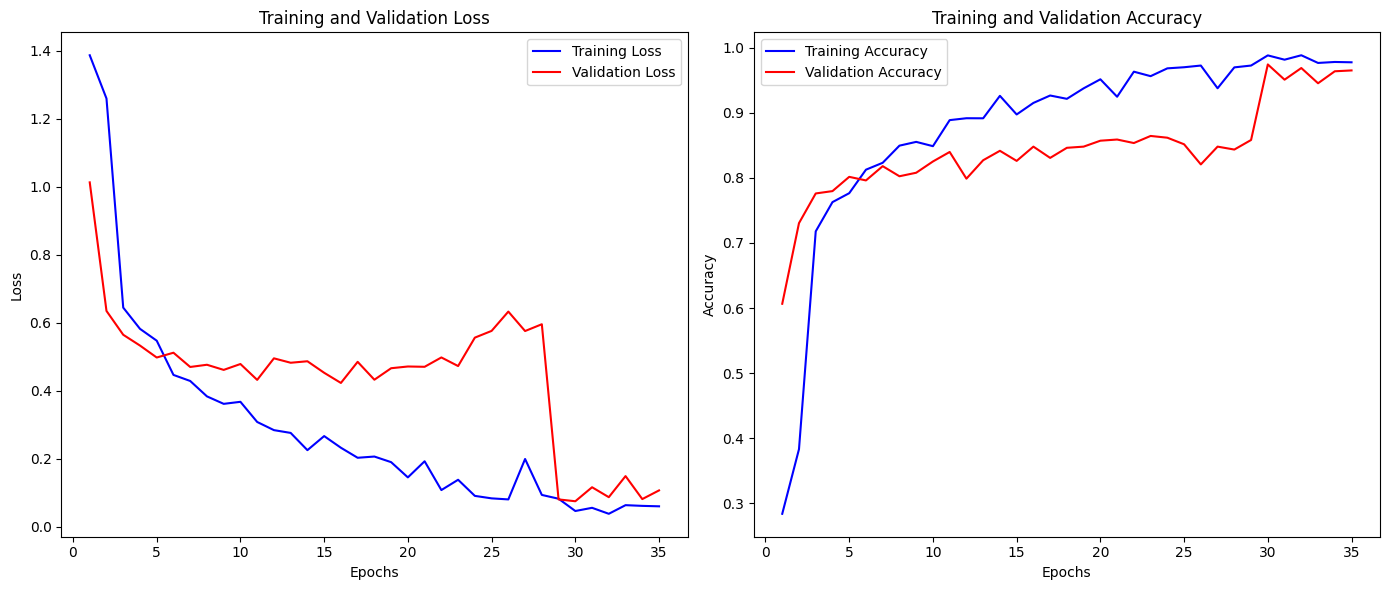

In [53]:
import matplotlib.pyplot as plt

# Data from each epoch
train_data = [
    (0.2841, 1.3873), (0.3833, 1.2600), (0.7178, 0.6450), (0.7627, 0.5826), (0.7764, 0.5477),
    (0.8125, 0.4470), (0.8231, 0.4292), (0.8494, 0.3839), (0.8552, 0.3619), (0.8486, 0.3679),
    (0.8886, 0.3086), (0.8915, 0.2846), (0.8914, 0.2764), (0.9259, 0.2257), (0.8973, 0.2671),
    (0.9150, 0.2328), (0.9264, 0.2033), (0.9213, 0.2069), (0.9374, 0.1904), (0.9513, 0.1456),
    (0.9245, 0.1930), (0.9630, 0.1083), (0.9561, 0.1386), (0.9681, 0.0912), (0.9698, 0.0839),
    (0.9724, 0.0808), (0.9375, 0.1997), (0.9696, 0.0940), (0.9724, 0.0828), (0.9880, 0.0467),
    (0.9814, 0.0561), (0.9882, 0.0385), (0.9764, 0.0639), (0.9779, 0.0618), (0.9774, 0.0605)
]
val_data = [
    (0.6066, 1.0134), (0.7304, 0.6352), (0.7760, 0.5651), (0.7796, 0.5334), (0.8015, 0.4982),
    (0.7960, 0.5123), (0.8179, 0.4704), (0.8024, 0.4769), (0.8078, 0.4618), (0.8251, 0.4791),
    (0.8397, 0.4324), (0.7987, 0.4958), (0.8270, 0.4828), (0.8415, 0.4872), (0.8260, 0.4533),
    (0.8479, 0.4234), (0.8306, 0.4855), (0.8461, 0.4329), (0.8479, 0.4667), (0.8570, 0.4718),
    (0.8588, 0.4709), (0.8534, 0.4984), (0.8643, 0.4731), (0.8616, 0.5567), (0.8515, 0.5765),
    (0.8206, 0.6333), (0.8479, 0.5761), (0.8434, 0.5961), (0.8581, 0.0808), (0.9741, 0.0754),
    (0.9507, 0.1166), (0.9686, 0.0874), (0.9452, 0.1494), (0.9636, 0.0818), (0.9649, 0.1073)
]

# Extracting training and validation accuracy and loss
train_accuracy = [data[0] for data in train_data]
train_loss = [data[1] for data in train_data]
val_accuracy = [data[0] for data in val_data]
val_loss = [data[1] for data in val_data]

# Number of epochs
epochs = range(1, len(train_accuracy) + 1)

# Plotting the metrics
plt.figure(figsize=(14, 6))

# Plot training loss and validation loss
plt.subplot(1, 2, 1)
plt.plot(epochs, train_loss, 'b-', label='Training Loss')
plt.plot(epochs, val_loss, 'r-', label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Plot training accuracy and validation accuracy
plt.subplot(1, 2, 2)
plt.plot(epochs, train_accuracy, 'b-', label='Training Accuracy')
plt.plot(epochs, val_accuracy, 'r-', label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()
